<h1><center>RL-CAB Driver : Architecture 1 and 2</center></h1>

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### <font color =blue> There are certain data points in time matrix which have 0 values and these were causing our code to go in loop. To avoid this we have added a dummy 1 hour increment to break out of the loop which is equivalent to driver rejecting the ride.</font>

In [4]:
print((Time_matrix[2][3][22][3]))

0.0


In [5]:
print((Time_matrix[2][2][22][3]))

0.0


In [6]:
print((Time_matrix[0][3][19][0]))

0.0


### <font color =blue> The problem can be defined as for given set of states/time pair finding the best action(location pair) but since the location pair has lot of values we should ideally use Architecture 1 as in Architecture 2 we get the q-value for each action. But on the other hand the Architecture 2 is going to be comparatively very fast. Also the combination of state and the action pairs which we have to pass to them will make the training difficult. We have tried both approaches just to try to get familiar with both approaches </font>

## <font color =green>Architecture 1 passing State and Action pair to the Neural Net</font>

In [11]:
class DQNAgentArch1:
    def __init__(self, state_size, action_size,epsilon=1,epsilon_min=0.00001,discount_factor=0.95, epsilon_decay=0.0003
                 ,learning_rate=0.001):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the list to strore the values of the states tracked
        self.states_tracked = []
        
        # We will track state [0,0,0] and action (0,2) , since this is Architecture 1 we will pass both state and action
        # as a pair and will reshape it to be passed to the model
        self.track_state = np.array(env.state_encod_arch2([0,0,0],[0,0])).reshape(1, 46 )

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        # Write your code here: Add layers to your neural nets
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output always 1 q-value for the action on a given state
        model.add(Dense(1, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, action_space,possible_actions_index):    
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            action_index = random.choice(possible_actions_index)
            max_action = env.action_space[action_index]
            return action
        else:
            # choose the action with the highest q-value from all the possible actions
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            max_action = action_space[possible_actions_index[0]]
            action_index =possible_actions_index[0] 
            max_value = -10000            # random bad q-value for comparison
            ### loop through all the possible actions to find the max q-value
            for i in possible_actions_index:
                ##print("State: {0}".format(state) )
                ##print("Action: {0}" .format(action_space[i]))
                state2 = np.array(state).reshape(1, self.state_size)
                q_value = self.model.predict(state2)[0][0]
                #### if the q value for this action is greater than previously taken action choose this action
                if q_value > max_value:
                    max_value = q_value
                    max_action = action_space[i]
                    action_index = i
            return max_action

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = state     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                        
            # 3. Update your 'update_output' and 'update_input' batch


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i] = rewards[i]
                else: # non-terminal state
                    target[i] = rewards[i] + self.discount_factor * target_qval[i][0]
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)[0][0]
        # Save the value in the list 
        self.states_tracked.append(q_value)


In [12]:
# Our cab needs to be recharged after 30 days
episode_time = 24*30
Episodes = 1

# Invoke Env class
env = CabDriver()
action_space, state_space, state ,action = env.reset_arch1()

# Set up state and action sizes.
state_size =len(env.state_encod_arch2(env.state_init,env.action_init))
action_size = len(env.action_space)

# Invoke agent class
agent = DQNAgentArch1(action_size=action_size, state_size=state_size,discount_factor=0.95, epsilon_decay=0.0003
                 ,learning_rate=0.001)

# to store rewards in each episode
rewards_per_episode_arch1, episodes_arch1 = [], []


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                1504      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________


In [13]:
def DQN_run_arch1(Episodes =2 ,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003):
    start_time = time.time()
    print('Starting :',start_time)
    
    for episode in range(Episodes):
        
        done = False
        score = 0
        track_reward = False
        
        # reset at the start of each episode
        env = CabDriver()
        action_space, state_space, state,action = env.reset_arch1()
        # Save the initial state so that reward can be tracked if initial state is [0,0,0]
        initial_state = env.state_init
        initial_action = env.action_init
        
        total_time = 0  # Total time driver rode in this episode
        while not done:
            # 1. Get a list of the ride requests driver got.
            possible_actions_indices, actions = env.requests(state)
            
            # 2. Pick epsilon-greedy action from possible actions for the current state.
            action = agent.get_action(env.state_encod_arch2(state,action),env.action_space ,possible_actions_indices)
            
            # 3. Evaluate your reward and next state
            reward, next_state, step_time = env.reward_func(state, action, Time_matrix)
            
            # 2. Pick epsilon-greedy action from possible actions for the current state.
            next_action = agent.get_action(env.state_encod_arch2(next_state,action),env.action_space ,possible_actions_indices)
            
            # 4. Total time driver rode in this episode
            total_time += step_time
            if (total_time > episode_time):
                # if ride does not complete in stipu;ated time skip
                # it and move to next episode.
                done = True
            else:
                # 5. Append the experience to the memory
                agent.append_sample(env.state_encod_arch2(state,action), action, reward, env.state_encod_arch2(next_state,next_action), done)
                
                # 6. Train the model by calling function agent.train_model
                agent.train_model()
                
                # 7. Keep a track of rewards, Q-values, loss
                score += reward
                state = next_state
        
        # store total reward obtained in this episode
        rewards_per_episode_arch1.append(score)
        episodes_arch1.append(episode)
        
        
        # epsilon decay
        agent.epsilon = agent.epsilon_min + (1 - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)
        
        # every 10 episodes:
        if ((episode + 1) % 10 == 0):
            print("Episode {0}, Total_Reward {1}, Memory_Length {2}, Epsilon {3} ".format(episode,score,len(agent.memory),agent.epsilon))
        
        # Save the Q_value of the state, action pair we are tracking
        if ((episode + 1) % 10 == 0):
            agent.save_tracking_states()
        
        
                
        if(episode % 1000 == 0) and (episode > 0 ):
            print("Saving Model {}".format(episode))
            json_file_path = "model_arch1_weights.json"
            json_file = agent.model.to_json()
            with open(json_file_path, "w") as file:
                file.write(json_file)
            agent.model.save_weights("model_arch1_weights.h5")
            
    print("Saving Final Model and weights")
    json_file_path = "final_model_arch1_weights.json"
    json_file = agent.model.to_json()
    with open(json_file_path, "w") as file:
                file.write(json_file)
    agent.model.save_weights("final_model__arch1_weights.h5")
            
    
    elapsed_time = time.time() - start_time
    print(elapsed_time)

In [14]:
#### Sanity check
DQN_run_arch1(Episodes = 2,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003)

Starting : 1604304499.3614733
Saving Final Model and weights
2.5529215335845947


In [12]:
DQN_run_arch1(Episodes = 10000,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003)

Starting : 1604295530.3178985
Episode 9, Total_Reward -605.0, Memory_Length 2000, Epsilon 0.997303668685296 
Episode 19, Total_Reward -376.0, Memory_Length 2000, Epsilon 0.9943162710162915 
Episode 29, Total_Reward -1109.0, Memory_Length 2000, Epsilon 0.9913378221104377 
Episode 39, Total_Reward -1737.0, Memory_Length 2000, Epsilon 0.9883682951616745 
Episode 49, Total_Reward -2115.0, Memory_Length 2000, Epsilon 0.985407663444239 
Episode 59, Total_Reward -983.0, Memory_Length 2000, Epsilon 0.982455900312426 
Episode 69, Total_Reward -252.0, Memory_Length 2000, Epsilon 0.9795129792003474 
Episode 79, Total_Reward -346.0, Memory_Length 2000, Epsilon 0.9765788736216932 
Episode 89, Total_Reward -639.0, Memory_Length 2000, Epsilon 0.9736535571694933 
Episode 99, Total_Reward -774.0, Memory_Length 2000, Epsilon 0.9707370035158802 
Episode 109, Total_Reward -367.0, Memory_Length 2000, Epsilon 0.9678291864118511 
Episode 119, Total_Reward -371.0, Memory_Length 2000, Epsilon 0.964930079687032

Saving Model 1000
Episode 1009, Total_Reward -413.0, Memory_Length 2000, Epsilon 0.7388233211325836 
Episode 1019, Total_Reward -102.0, Memory_Length 2000, Epsilon 0.7366102025069631 
Episode 1029, Total_Reward -696.0, Memory_Length 2000, Epsilon 0.7344037132881369 
Episode 1039, Total_Reward -143.0, Memory_Length 2000, Epsilon 0.7322038336176877 
Episode 1049, Total_Reward -853.0, Memory_Length 2000, Epsilon 0.7300105436966834 
Episode 1059, Total_Reward -601.0, Memory_Length 2000, Epsilon 0.7278238237854998 
Episode 1069, Total_Reward -57.0, Memory_Length 2000, Epsilon 0.725643654203643 
Episode 1079, Total_Reward -306.0, Memory_Length 2000, Epsilon 0.7234700153295721 
Episode 1089, Total_Reward -323.0, Memory_Length 2000, Epsilon 0.7213028876005225 
Episode 1099, Total_Reward -84.0, Memory_Length 2000, Epsilon 0.71914225151233 
Episode 1109, Total_Reward -216.0, Memory_Length 2000, Epsilon 0.7169880876192554 
Episode 1119, Total_Reward -397.0, Memory_Length 2000, Epsilon 0.714840376

Episode 1999, Total_Reward -234.0, Memory_Length 2000, Epsilon 0.5489808145208053 
Saving Model 2000
Episode 2009, Total_Reward -301.0, Memory_Length 2000, Epsilon 0.5473363699773912 
Episode 2019, Total_Reward -220.0, Memory_Length 2000, Epsilon 0.5456968513750013 
Episode 2029, Total_Reward -351.0, Memory_Length 2000, Epsilon 0.5440622439579573 
Episode 2039, Total_Reward -459.0, Memory_Length 2000, Epsilon 0.5424325330147812 
Episode 2049, Total_Reward -137.0, Memory_Length 2000, Epsilon 0.5408077038780637 
Episode 2059, Total_Reward -295.0, Memory_Length 2000, Epsilon 0.5391877419243314 
Episode 2069, Total_Reward -436.0, Memory_Length 2000, Epsilon 0.5375726325739159 
Episode 2079, Total_Reward -372.0, Memory_Length 2000, Epsilon 0.535962361290822 
Episode 2089, Total_Reward -252.0, Memory_Length 2000, Epsilon 0.5343569135825975 
Episode 2099, Total_Reward -629.0, Memory_Length 2000, Epsilon 0.5327562750002021 
Episode 2109, Total_Reward 167.0, Memory_Length 2000, Epsilon 0.531160

Episode 2989, Total_Reward -450.0, Memory_Length 2000, Epsilon 0.4079194766911415 
Episode 2999, Total_Reward 15.0, Memory_Length 2000, Epsilon 0.40669758201949635 
Saving Model 3000
Episode 3009, Total_Reward -45.0, Memory_Length 2000, Epsilon 0.4054793475388346 
Episode 3019, Total_Reward -25.0, Memory_Length 2000, Epsilon 0.4042647622850376 
Episode 3029, Total_Reward 47.0, Memory_Length 2000, Epsilon 0.4030538153268299 
Episode 3039, Total_Reward 63.0, Memory_Length 2000, Epsilon 0.40184649576568066 
Episode 3049, Total_Reward -297.0, Memory_Length 2000, Epsilon 0.4006427927357057 
Episode 3059, Total_Reward -189.0, Memory_Length 2000, Epsilon 0.39944269540356964 
Episode 3069, Total_Reward -125.0, Memory_Length 2000, Epsilon 0.39824619296838837 
Episode 3079, Total_Reward -171.0, Memory_Length 2000, Epsilon 0.397053274661632 
Episode 3089, Total_Reward -458.0, Memory_Length 2000, Epsilon 0.3958639297470275 
Episode 3099, Total_Reward -57.0, Memory_Length 2000, Epsilon 0.3946781475

Episode 3979, Total_Reward -376.0, Memory_Length 2000, Epsilon 0.3031046942410449 
Episode 3989, Total_Reward -233.0, Memory_Length 2000, Epsilon 0.30219677272154216 
Episode 3999, Total_Reward -297.0, Memory_Length 2000, Epsilon 0.30129157088503344 
Saving Model 4000
Episode 4009, Total_Reward 105.0, Memory_Length 2000, Epsilon 0.30038908058469654 
Episode 4019, Total_Reward -290.0, Memory_Length 2000, Epsilon 0.2994892936981124 
Episode 4029, Total_Reward -147.0, Memory_Length 2000, Epsilon 0.298592202127193 
Episode 4039, Total_Reward -367.0, Memory_Length 2000, Epsilon 0.2976977977981082 
Episode 4049, Total_Reward -426.0, Memory_Length 2000, Epsilon 0.296806072661213 
Episode 4059, Total_Reward -214.0, Memory_Length 2000, Epsilon 0.29591701869097514 
Episode 4069, Total_Reward -342.0, Memory_Length 2000, Epsilon 0.29503062788590273 
Episode 4079, Total_Reward -175.0, Memory_Length 2000, Epsilon 0.29414689226847285 
Episode 4089, Total_Reward 20.0, Memory_Length 2000, Epsilon 0.293

Episode 4969, Total_Reward -48.0, Memory_Length 2000, Epsilon 0.22522269773448136 
Episode 4979, Total_Reward -291.0, Memory_Length 2000, Epsilon 0.22454807208572028 
Episode 4989, Total_Reward -89.0, Memory_Length 2000, Epsilon 0.2238754672811235 
Episode 4999, Total_Reward -125.0, Memory_Length 2000, Epsilon 0.22320487726724342 
Saving Model 5000
Episode 5009, Total_Reward -346.0, Memory_Length 2000, Epsilon 0.22253629600876523 
Episode 5019, Total_Reward -148.0, Memory_Length 2000, Epsilon 0.22186971748845324 
Episode 5029, Total_Reward -385.0, Memory_Length 2000, Epsilon 0.22120513570709616 
Episode 5039, Total_Reward -363.0, Memory_Length 2000, Epsilon 0.22054254468345355 
Episode 5049, Total_Reward -216.0, Memory_Length 2000, Epsilon 0.21988193845420165 
Episode 5059, Total_Reward -66.0, Memory_Length 2000, Epsilon 0.21922331107388002 
Episode 5069, Total_Reward -103.0, Memory_Length 2000, Epsilon 0.21856665661483768 
Episode 5079, Total_Reward -367.0, Memory_Length 2000, Epsilon

Episode 5959, Total_Reward 541.0, Memory_Length 2000, Epsilon 0.16735294655948582 
Episode 5969, Total_Reward -424.0, Memory_Length 2000, Epsilon 0.1668516700105881 
Episode 5979, Total_Reward -76.0, Memory_Length 2000, Epsilon 0.1663518950378466 
Episode 5989, Total_Reward -65.0, Memory_Length 2000, Epsilon 0.16585361714328326 
Episode 5999, Total_Reward -58.0, Memory_Length 2000, Epsilon 0.16535683184239366 
Saving Model 6000
Episode 6009, Total_Reward -183.0, Memory_Length 2000, Epsilon 0.16486153466410675 
Episode 6019, Total_Reward -135.0, Memory_Length 2000, Epsilon 0.16436772115074455 
Episode 6029, Total_Reward -81.0, Memory_Length 2000, Epsilon 0.16387538685798214 
Episode 6039, Total_Reward -92.0, Memory_Length 2000, Epsilon 0.1633845273548075 
Episode 6049, Total_Reward 113.0, Memory_Length 2000, Epsilon 0.16289513822348187 
Episode 6059, Total_Reward -418.0, Memory_Length 2000, Epsilon 0.1624072150594997 
Episode 6069, Total_Reward 14.0, Memory_Length 2000, Epsilon 0.161920

Episode 6949, Total_Reward 104.0, Memory_Length 2000, Epsilon 0.12435317445203002 
Episode 6959, Total_Reward -162.0, Memory_Length 2000, Epsilon 0.12398070391383406 
Episode 6969, Total_Reward -52.0, Memory_Length 2000, Epsilon 0.12360934911281014 
Episode 6979, Total_Reward 43.0, Memory_Length 2000, Epsilon 0.1232391067067626 
Episode 6989, Total_Reward 353.0, Memory_Length 2000, Epsilon 0.12286997336350713 
Episode 6999, Total_Reward -334.0, Memory_Length 2000, Epsilon 0.12250194576084127 
Saving Model 7000
Episode 7009, Total_Reward 39.0, Memory_Length 2000, Epsilon 0.12213502058651406 
Episode 7019, Total_Reward -181.0, Memory_Length 2000, Epsilon 0.12176919453819653 
Episode 7029, Total_Reward -263.0, Memory_Length 2000, Epsilon 0.12140446432345166 
Episode 7039, Total_Reward -112.0, Memory_Length 2000, Epsilon 0.12104082665970511 
Episode 7049, Total_Reward 212.0, Memory_Length 2000, Epsilon 0.12067827827421547 
Episode 7059, Total_Reward -125.0, Memory_Length 2000, Epsilon 0.12

Episode 7939, Total_Reward -13.0, Memory_Length 2000, Epsilon 0.09240245125465701 
Episode 7949, Total_Reward -45.0, Memory_Length 2000, Epsilon 0.09212568925146933 
Episode 7959, Total_Reward 118.0, Memory_Length 2000, Epsilon 0.09184975629010665 
Episode 7969, Total_Reward -43.0, Memory_Length 2000, Epsilon 0.0915746498871705 
Episode 7979, Total_Reward 338.0, Memory_Length 2000, Epsilon 0.09130036756670137 
Episode 7989, Total_Reward -53.0, Memory_Length 2000, Epsilon 0.09102690686015663 
Episode 7999, Total_Reward 27.0, Memory_Length 2000, Epsilon 0.09075426530638793 
Saving Model 8000
Episode 8009, Total_Reward -132.0, Memory_Length 2000, Epsilon 0.09048244045161952 
Episode 8019, Total_Reward -147.0, Memory_Length 2000, Epsilon 0.09021142984942587 
Episode 8029, Total_Reward -144.0, Memory_Length 2000, Epsilon 0.08994123106070975 
Episode 8039, Total_Reward 2.0, Memory_Length 2000, Epsilon 0.08967184165368017 
Episode 8049, Total_Reward -37.0, Memory_Length 2000, Epsilon 0.089403

Episode 8929, Total_Reward -99.0, Memory_Length 2000, Epsilon 0.06866165769221531 
Episode 8939, Total_Reward -73.0, Memory_Length 2000, Epsilon 0.06845601134289737 
Episode 8949, Total_Reward -273.0, Memory_Length 2000, Epsilon 0.06825098100814353 
Episode 8959, Total_Reward -300.0, Memory_Length 2000, Epsilon 0.0680465648426794 
Episode 8969, Total_Reward -171.0, Memory_Length 2000, Epsilon 0.06784276100675811 
Episode 8979, Total_Reward -111.0, Memory_Length 2000, Epsilon 0.06763956766614372 
Episode 8989, Total_Reward -51.0, Memory_Length 2000, Epsilon 0.06743698299209484 
Episode 8999, Total_Reward 91.0, Memory_Length 2000, Epsilon 0.06723500516134806 
Saving Model 9000
Episode 9009, Total_Reward -299.0, Memory_Length 2000, Epsilon 0.06703363235610146 
Episode 9019, Total_Reward 31.0, Memory_Length 2000, Epsilon 0.06683286276399847 
Episode 9029, Total_Reward -84.0, Memory_Length 2000, Epsilon 0.06663269457811141 
Episode 9039, Total_Reward -175.0, Memory_Length 2000, Epsilon 0.06

Episode 9909, Total_Reward 36.0, Memory_Length 2000, Epsilon 0.051174466576619886 
Episode 9919, Total_Reward 108.0, Memory_Length 2000, Epsilon 0.05102120318692209 
Episode 9929, Total_Reward -323.0, Memory_Length 2000, Epsilon 0.0508683988983973 
Episode 9939, Total_Reward 180.0, Memory_Length 2000, Epsilon 0.05071605233580592 
Episode 9949, Total_Reward -140.0, Memory_Length 2000, Epsilon 0.050564162128027806 
Episode 9959, Total_Reward 208.0, Memory_Length 2000, Epsilon 0.050412726908050084 
Episode 9969, Total_Reward -125.0, Memory_Length 2000, Epsilon 0.05026174531295475 
Episode 9979, Total_Reward -27.0, Memory_Length 2000, Epsilon 0.05011121598390646 
Episode 9989, Total_Reward -112.0, Memory_Length 2000, Epsilon 0.04996113756614018 
Episode 9999, Total_Reward -17.0, Memory_Length 2000, Epsilon 0.04981150870894916 
Saving Final Model and weights
8005.61029791832


#### <font color =blue>Ran the model for 10000 episodes with discount_factor  = .95 Learning rate 0.001 , decay rate: .0003 and two hidden layers but looks like the rewards are still negative for lot of actions. </font>

In [15]:
DQN_run_arch1(Episodes = 2000,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.001)

Starting : 1604304519.5830982
Episode 9, Total_Reward -360.0, Memory_Length 2000, Epsilon 0.997303668685296 
Episode 19, Total_Reward -615.0, Memory_Length 2000, Epsilon 0.9943162710162915 
Episode 29, Total_Reward -632.0, Memory_Length 2000, Epsilon 0.9913378221104377 
Episode 39, Total_Reward -311.0, Memory_Length 2000, Epsilon 0.9883682951616745 
Episode 49, Total_Reward -1404.0, Memory_Length 2000, Epsilon 0.985407663444239 
Episode 59, Total_Reward -1885.0, Memory_Length 2000, Epsilon 0.982455900312426 
Episode 69, Total_Reward -698.0, Memory_Length 2000, Epsilon 0.9795129792003474 
Episode 79, Total_Reward -334.0, Memory_Length 2000, Epsilon 0.9765788736216932 
Episode 89, Total_Reward -1804.0, Memory_Length 2000, Epsilon 0.9736535571694933 
Episode 99, Total_Reward -1804.0, Memory_Length 2000, Epsilon 0.9707370035158802 
Episode 109, Total_Reward -372.0, Memory_Length 2000, Epsilon 0.9678291864118511 
Episode 119, Total_Reward -998.0, Memory_Length 2000, Epsilon 0.96493007968703

Saving Model 1000
Episode 1009, Total_Reward -108.0, Memory_Length 2000, Epsilon 0.7388233211325836 
Episode 1019, Total_Reward -528.0, Memory_Length 2000, Epsilon 0.7366102025069631 
Episode 1029, Total_Reward -208.0, Memory_Length 2000, Epsilon 0.7344037132881369 
Episode 1039, Total_Reward -189.0, Memory_Length 2000, Epsilon 0.7322038336176877 
Episode 1049, Total_Reward -120.0, Memory_Length 2000, Epsilon 0.7300105436966834 
Episode 1059, Total_Reward -99.0, Memory_Length 2000, Epsilon 0.7278238237854998 
Episode 1069, Total_Reward -171.0, Memory_Length 2000, Epsilon 0.725643654203643 
Episode 1079, Total_Reward -565.0, Memory_Length 2000, Epsilon 0.7234700153295721 
Episode 1089, Total_Reward 94.0, Memory_Length 2000, Epsilon 0.7213028876005225 
Episode 1099, Total_Reward -60.0, Memory_Length 2000, Epsilon 0.71914225151233 
Episode 1109, Total_Reward -141.0, Memory_Length 2000, Epsilon 0.7169880876192554 
Episode 1119, Total_Reward -441.0, Memory_Length 2000, Epsilon 0.71484037653

#### <font color =blue>Ran the model for 2000 episodes with discount_factor = .95 Learning rate 0.001, decay rate : .001 and <span style='background:yellow'>three hidden layers</span> </font>

In [16]:
DQN_run_arch1(Episodes = 2000,discount_factor=0.85, learning_rate=0.005, epsilon_decay=0.01)

Starting : 1604306026.6344852
Episode 9, Total_Reward -1938.0, Memory_Length 2000, Epsilon 0.997303668685296 
Episode 19, Total_Reward -337.0, Memory_Length 2000, Epsilon 0.9943162710162915 
Episode 29, Total_Reward -351.0, Memory_Length 2000, Epsilon 0.9913378221104377 
Episode 39, Total_Reward -1656.0, Memory_Length 2000, Epsilon 0.9883682951616745 
Episode 49, Total_Reward -1830.0, Memory_Length 2000, Epsilon 0.985407663444239 
Episode 59, Total_Reward -342.0, Memory_Length 2000, Epsilon 0.982455900312426 
Episode 69, Total_Reward -396.0, Memory_Length 2000, Epsilon 0.9795129792003474 
Episode 79, Total_Reward -289.0, Memory_Length 2000, Epsilon 0.9765788736216932 
Episode 89, Total_Reward -538.0, Memory_Length 2000, Epsilon 0.9736535571694933 
Episode 99, Total_Reward -451.0, Memory_Length 2000, Epsilon 0.9707370035158802 
Episode 109, Total_Reward -184.0, Memory_Length 2000, Epsilon 0.9678291864118511 
Episode 119, Total_Reward -335.0, Memory_Length 2000, Epsilon 0.964930079687032

Saving Model 1000
Episode 1009, Total_Reward 17.0, Memory_Length 2000, Epsilon 0.7388233211325836 
Episode 1019, Total_Reward -168.0, Memory_Length 2000, Epsilon 0.7366102025069631 
Episode 1029, Total_Reward -283.0, Memory_Length 2000, Epsilon 0.7344037132881369 
Episode 1039, Total_Reward -297.0, Memory_Length 2000, Epsilon 0.7322038336176877 
Episode 1049, Total_Reward -242.0, Memory_Length 2000, Epsilon 0.7300105436966834 
Episode 1059, Total_Reward -440.0, Memory_Length 2000, Epsilon 0.7278238237854998 
Episode 1069, Total_Reward -53.0, Memory_Length 2000, Epsilon 0.725643654203643 
Episode 1079, Total_Reward -373.0, Memory_Length 2000, Epsilon 0.7234700153295721 
Episode 1089, Total_Reward -274.0, Memory_Length 2000, Epsilon 0.7213028876005225 
Episode 1099, Total_Reward -878.0, Memory_Length 2000, Epsilon 0.71914225151233 
Episode 1109, Total_Reward -454.0, Memory_Length 2000, Epsilon 0.7169880876192554 
Episode 1119, Total_Reward -264.0, Memory_Length 2000, Epsilon 0.7148403765

#### <font color =blue>Even after adding another Neural Net layer we don't see a huge improvement in the rewards compared to same episode length in previous runs : <span style='background:yellow'>additional changes in discount factor , learning rate and decay</span></font>

In [17]:
DQN_run_arch1(Episodes = 2000,discount_factor=0.95, learning_rate=0.008, epsilon_decay=0.001)

Starting : 1604307490.1307535
Episode 9, Total_Reward -349.0, Memory_Length 2000, Epsilon 0.997303668685296 
Episode 19, Total_Reward -375.0, Memory_Length 2000, Epsilon 0.9943162710162915 
Episode 29, Total_Reward -369.0, Memory_Length 2000, Epsilon 0.9913378221104377 
Episode 39, Total_Reward -346.0, Memory_Length 2000, Epsilon 0.9883682951616745 
Episode 49, Total_Reward -389.0, Memory_Length 2000, Epsilon 0.985407663444239 
Episode 59, Total_Reward -333.0, Memory_Length 2000, Epsilon 0.982455900312426 
Episode 69, Total_Reward -324.0, Memory_Length 2000, Epsilon 0.9795129792003474 
Episode 79, Total_Reward -664.0, Memory_Length 2000, Epsilon 0.9765788736216932 
Episode 89, Total_Reward -342.0, Memory_Length 2000, Epsilon 0.9736535571694933 
Episode 99, Total_Reward -360.0, Memory_Length 2000, Epsilon 0.9707370035158802 
Episode 109, Total_Reward -616.0, Memory_Length 2000, Epsilon 0.9678291864118511 
Episode 119, Total_Reward -1915.0, Memory_Length 2000, Epsilon 0.9649300796870326 

Saving Model 1000
Episode 1009, Total_Reward -244.0, Memory_Length 2000, Epsilon 0.7388233211325836 
Episode 1019, Total_Reward -341.0, Memory_Length 2000, Epsilon 0.7366102025069631 
Episode 1029, Total_Reward -413.0, Memory_Length 2000, Epsilon 0.7344037132881369 
Episode 1039, Total_Reward -199.0, Memory_Length 2000, Epsilon 0.7322038336176877 
Episode 1049, Total_Reward -231.0, Memory_Length 2000, Epsilon 0.7300105436966834 
Episode 1059, Total_Reward -152.0, Memory_Length 2000, Epsilon 0.7278238237854998 
Episode 1069, Total_Reward -216.0, Memory_Length 2000, Epsilon 0.725643654203643 
Episode 1079, Total_Reward -688.0, Memory_Length 2000, Epsilon 0.7234700153295721 
Episode 1089, Total_Reward -134.0, Memory_Length 2000, Epsilon 0.7213028876005225 
Episode 1099, Total_Reward -9.0, Memory_Length 2000, Epsilon 0.71914225151233 
Episode 1109, Total_Reward -249.0, Memory_Length 2000, Epsilon 0.7169880876192554 
Episode 1119, Total_Reward -531.0, Memory_Length 2000, Epsilon 0.714840376

#### <font color =blue>Even after adding another Neural Net layer we don't see a huge improvement in the rewards compared to same episode length in previous runs : <span style='background:yellow'>additionally modified the epsilon decay and learning rate as well</span></font>

## <font color =green>Architecture 2 passing state as input to neural network</font>

In [7]:
class DQNAgentArch2:
    def __init__(self, state_size, action_size,epsilon=1,epsilon_min=0.00001,discount_factor=0.95, epsilon_decay=0.0003
                 ,learning_rate=0.001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the list to strore the values of the states tracked
        self.states_tracked = []
        
        # Tracking state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        # Write your code here: Add layers to your neural nets    
        model = Sequential()
           
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(state).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = state     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            
            # 3. Update your 'update_output' and 'update_input' batch


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        

In [8]:
## Our cab runs for 30 days after which it will have to be taken for charging
episode_time = 24*30 
Episodes = 1

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size =len(env.state_encod_arch1(env.state_init))
action_size = len(env.action_space)

# Invoke agent class
agent_arch2 = DQNAgentArch2(action_size=action_size, state_size=state_size,discount_factor=0.95, epsilon_decay=0.0003
                 ,learning_rate=0.001)

# to store rewards in each episode
rewards_per_episode_arch2, episodes_arch2 = [], []


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


In [9]:
def DQN_run_arch2(Episodes =2 ,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003):
    
    start_time = time.time()
    print('Starting :',start_time)
        
    for episode in range(Episodes):
        
        done = False
        score = 0
        track_reward = False
        
        # reset at the start of each episode
        
        env = CabDriver()
        action_space, state_space, state = env.reset()
        
        # Save the initial state so that reward can be tracked if initial state is [0,0,0]
        initial_state = env.state_init
        
        total_time = 0  # Total time driver rode in this episode
        while not done:
            
            # 1. Get a list of the ride requests driver got.
            possible_actions_indices, actions = env.requests(state)
            
            # 2. Pick epsilon-greedy action from possible actions for the current state.
            action = agent_arch2.get_action(env.state_encod_arch1(state), possible_actions_indices)
            
            # 3. Evaluate your reward and next state
            reward, next_state, step_time = env.reward_func(state, env.action_space[action], Time_matrix)
            
            # 4. Total time driver rode in this episode
            total_time += step_time
            if (total_time > episode_time):
                # if ride does not complete in stipu;ated time skip
                # it and move to next episode.
                done = True
            else:
                # 5. Append the experience to the memory
                agent_arch2.append_sample(env.state_encod_arch1(state), action, reward, env.state_encod_arch1(next_state), done)
                
                # 6. Train the model by calling function agent.train_model
                agent_arch2.train_model()
                
                # 7. Keep a track of rewards, Q-values, loss
                score += reward
                state = next_state
        
        # store total reward obtained in this episode
        rewards_per_episode_arch2.append(score)
        episodes_arch2.append(episode)
        
        # epsilon decay
        agent_arch2.epsilon = agent_arch2.epsilon_min + ( 1  - agent_arch2.epsilon_min) * np.exp(-agent_arch2.epsilon_decay*episode)
        
        
        # every 10 episodes:
        if ((episode + 1) % 10 == 0):
            print("Episode {0}, Total_Reward {1}, memory_length {2}, epsilon {3}".format(episode,score,len(agent_arch2.memory),agent_arch2.epsilon ))
            
        # Save the Q_value of the state, action pair we are tracking
        if ((episode + 1) % 10 == 0):
            agent_arch2.save_tracking_states()
        
        
        
        if(episode % 1000 == 0) and (episode > 0):
            print("Saving Model {}".format(episode))
            json_file_path = "model_weights.json"
            json_file = agent_arch2.model.to_json()
            with open(json_file_path, "w") as file:
                file.write(json_file)
            agent_arch2.model.save_weights("model_weights.h5")
            
    print("Saving Final Model and weights")
    json_file_path = "final_model_weights.json"
    json_file = agent_arch2.model.to_json()
    with open(json_file_path, "w") as file:
                file.write(json_file)
    agent_arch2.model.save_weights("final_model_weights.h5")
            
    elapsed_time = time.time() - start_time
    print(elapsed_time)

In [10]:
#### Sanity Check
DQN_run_arch2(Episodes =2 ,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003)

Starting : 1604312616.410757
Saving Final Model and weights
2.895867347717285


In [22]:
DQN_run_arch2(Episodes =2000 ,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003)

Starting : 1604309150.8219702
Episode 9, Total_Reward -315.0, memory_length 1668, epsilon 0.997303668685296
Episode 19, Total_Reward -129.0, memory_length 2000, epsilon 0.9943162710162915
Episode 29, Total_Reward 72.0, memory_length 2000, epsilon 0.9913378221104377
Episode 39, Total_Reward -345.0, memory_length 2000, epsilon 0.9883682951616745
Episode 49, Total_Reward -341.0, memory_length 2000, epsilon 0.985407663444239
Episode 59, Total_Reward 230.0, memory_length 2000, epsilon 0.982455900312426
Episode 69, Total_Reward -105.0, memory_length 2000, epsilon 0.9795129792003474
Episode 79, Total_Reward 98.0, memory_length 2000, epsilon 0.9765788736216932
Episode 89, Total_Reward -47.0, memory_length 2000, epsilon 0.9736535571694933
Episode 99, Total_Reward -43.0, memory_length 2000, epsilon 0.9707370035158802
Episode 109, Total_Reward -333.0, memory_length 2000, epsilon 0.9678291864118511
Episode 119, Total_Reward -80.0, memory_length 2000, epsilon 0.9649300796870326
Episode 129, Total_R

Episode 1029, Total_Reward -238.0, memory_length 2000, epsilon 0.7344037132881369
Episode 1039, Total_Reward 13.0, memory_length 2000, epsilon 0.7322038336176877
Episode 1049, Total_Reward 122.0, memory_length 2000, epsilon 0.7300105436966834
Episode 1059, Total_Reward 389.0, memory_length 2000, epsilon 0.7278238237854998
Episode 1069, Total_Reward 27.0, memory_length 2000, epsilon 0.725643654203643
Episode 1079, Total_Reward 113.0, memory_length 2000, epsilon 0.7234700153295721
Episode 1089, Total_Reward 244.0, memory_length 2000, epsilon 0.7213028876005225
Episode 1099, Total_Reward 285.0, memory_length 2000, epsilon 0.71914225151233
Episode 1109, Total_Reward 453.0, memory_length 2000, epsilon 0.7169880876192554
Episode 1119, Total_Reward 139.0, memory_length 2000, epsilon 0.7148403765338088
Episode 1129, Total_Reward 154.0, memory_length 2000, epsilon 0.7126990989265762
Episode 1139, Total_Reward 721.0, memory_length 2000, epsilon 0.7105642355260446
Episode 1149, Total_Reward -17.0

#### <font color =blue>With an epsiode length of 2000 and using discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003 we do see a decent reward build up</font> 

In [23]:
DQN_run_arch2(Episodes =4000 ,discount_factor=0.90, learning_rate=0.005, epsilon_decay=0.0009)

Starting : 1604310085.9550574
Episode 9, Total_Reward -175.0, memory_length 2000, epsilon 0.997303668685296
Episode 19, Total_Reward -313.0, memory_length 2000, epsilon 0.9943162710162915
Episode 29, Total_Reward -328.0, memory_length 2000, epsilon 0.9913378221104377
Episode 39, Total_Reward -242.0, memory_length 2000, epsilon 0.9883682951616745
Episode 49, Total_Reward -116.0, memory_length 2000, epsilon 0.985407663444239
Episode 59, Total_Reward -245.0, memory_length 2000, epsilon 0.982455900312426
Episode 69, Total_Reward -319.0, memory_length 2000, epsilon 0.9795129792003474
Episode 79, Total_Reward -175.0, memory_length 2000, epsilon 0.9765788736216932
Episode 89, Total_Reward -80.0, memory_length 2000, epsilon 0.9736535571694933
Episode 99, Total_Reward 158.0, memory_length 2000, epsilon 0.9707370035158802
Episode 109, Total_Reward -343.0, memory_length 2000, epsilon 0.9678291864118511
Episode 119, Total_Reward 112.0, memory_length 2000, epsilon 0.9649300796870326
Episode 129, To

Episode 1029, Total_Reward 370.0, memory_length 2000, epsilon 0.7344037132881369
Episode 1039, Total_Reward 371.0, memory_length 2000, epsilon 0.7322038336176877
Episode 1049, Total_Reward 557.0, memory_length 2000, epsilon 0.7300105436966834
Episode 1059, Total_Reward 154.0, memory_length 2000, epsilon 0.7278238237854998
Episode 1069, Total_Reward -40.0, memory_length 2000, epsilon 0.725643654203643
Episode 1079, Total_Reward 253.0, memory_length 2000, epsilon 0.7234700153295721
Episode 1089, Total_Reward 291.0, memory_length 2000, epsilon 0.7213028876005225
Episode 1099, Total_Reward 155.0, memory_length 2000, epsilon 0.71914225151233
Episode 1109, Total_Reward 555.0, memory_length 2000, epsilon 0.7169880876192554
Episode 1119, Total_Reward 186.0, memory_length 2000, epsilon 0.7148403765338088
Episode 1129, Total_Reward 380.0, memory_length 2000, epsilon 0.7126990989265762
Episode 1139, Total_Reward 168.0, memory_length 2000, epsilon 0.7105642355260446
Episode 1149, Total_Reward 486.

Episode 2049, Total_Reward 927.0, memory_length 2000, epsilon 0.5408077038780637
Episode 2059, Total_Reward 898.0, memory_length 2000, epsilon 0.5391877419243314
Episode 2069, Total_Reward 649.0, memory_length 2000, epsilon 0.5375726325739159
Episode 2079, Total_Reward 432.0, memory_length 2000, epsilon 0.535962361290822
Episode 2089, Total_Reward 716.0, memory_length 2000, epsilon 0.5343569135825975
Episode 2099, Total_Reward 516.0, memory_length 2000, epsilon 0.5327562750002021
Episode 2109, Total_Reward 729.0, memory_length 2000, epsilon 0.5311604311378776
Episode 2119, Total_Reward 594.0, memory_length 2000, epsilon 0.5295693676330188
Episode 2129, Total_Reward 605.0, memory_length 2000, epsilon 0.527983070166043
Episode 2139, Total_Reward 691.0, memory_length 2000, epsilon 0.5264015244602627
Episode 2149, Total_Reward 828.0, memory_length 2000, epsilon 0.5248247162817556
Episode 2159, Total_Reward 608.0, memory_length 2000, epsilon 0.5232526314392376
Episode 2169, Total_Reward 735

Episode 3059, Total_Reward 1085.0, memory_length 2000, epsilon 0.39944269540356964
Episode 3069, Total_Reward 873.0, memory_length 2000, epsilon 0.39824619296838837
Episode 3079, Total_Reward 813.0, memory_length 2000, epsilon 0.397053274661632
Episode 3089, Total_Reward 1225.0, memory_length 2000, epsilon 0.3958639297470275
Episode 3099, Total_Reward 968.0, memory_length 2000, epsilon 0.3946781475204628
Episode 3109, Total_Reward 959.0, memory_length 2000, epsilon 0.3934959173098898
Episode 3119, Total_Reward 942.0, memory_length 2000, epsilon 0.39231722847522865
Episode 3129, Total_Reward 1294.0, memory_length 2000, epsilon 0.39114207040827187
Episode 3139, Total_Reward 1068.0, memory_length 2000, epsilon 0.3899704325325888
Episode 3149, Total_Reward 726.0, memory_length 2000, epsilon 0.3888023043034308
Episode 3159, Total_Reward 858.0, memory_length 2000, epsilon 0.3876376752076359
Episode 3169, Total_Reward 812.0, memory_length 2000, epsilon 0.3864765347635344
Episode 3179, Total_R

#### <font color =blue>With an epsiode length of 4000 and using discount_factor=0.90, learning_rate=0.005, epsilon_decay=0.0009 we see similar pattern in the reward build up</font> 

In [11]:
DQN_run_arch2(Episodes =20000 ,discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0002)

Starting : 1604312675.006892
Episode 9, Total_Reward -150.0, memory_length 1678, epsilon 0.997303668685296
Episode 19, Total_Reward -63.0, memory_length 2000, epsilon 0.9943162710162915
Episode 29, Total_Reward -108.0, memory_length 2000, epsilon 0.9913378221104377
Episode 39, Total_Reward -450.0, memory_length 2000, epsilon 0.9883682951616745
Episode 49, Total_Reward -215.0, memory_length 2000, epsilon 0.985407663444239
Episode 59, Total_Reward -598.0, memory_length 2000, epsilon 0.982455900312426
Episode 69, Total_Reward -314.0, memory_length 2000, epsilon 0.9795129792003474
Episode 79, Total_Reward 114.0, memory_length 2000, epsilon 0.9765788736216932
Episode 89, Total_Reward 9.0, memory_length 2000, epsilon 0.9736535571694933
Episode 99, Total_Reward -143.0, memory_length 2000, epsilon 0.9707370035158802
Episode 109, Total_Reward -207.0, memory_length 2000, epsilon 0.9678291864118511
Episode 119, Total_Reward -165.0, memory_length 2000, epsilon 0.9649300796870326
Episode 129, Total

Episode 1039, Total_Reward 50.0, memory_length 2000, epsilon 0.7322038336176877
Episode 1049, Total_Reward 18.0, memory_length 2000, epsilon 0.7300105436966834
Episode 1059, Total_Reward 335.0, memory_length 2000, epsilon 0.7278238237854998
Episode 1069, Total_Reward 164.0, memory_length 2000, epsilon 0.725643654203643
Episode 1079, Total_Reward 63.0, memory_length 2000, epsilon 0.7234700153295721
Episode 1089, Total_Reward 78.0, memory_length 2000, epsilon 0.7213028876005225
Episode 1099, Total_Reward 446.0, memory_length 2000, epsilon 0.71914225151233
Episode 1109, Total_Reward 2.0, memory_length 2000, epsilon 0.7169880876192554
Episode 1119, Total_Reward 322.0, memory_length 2000, epsilon 0.7148403765338088
Episode 1129, Total_Reward 245.0, memory_length 2000, epsilon 0.7126990989265762
Episode 1139, Total_Reward 387.0, memory_length 2000, epsilon 0.7105642355260446
Episode 1149, Total_Reward 635.0, memory_length 2000, epsilon 0.7084357671184289
Episode 1159, Total_Reward 209.0, mem

Episode 2059, Total_Reward 450.0, memory_length 2000, epsilon 0.5391877419243314
Episode 2069, Total_Reward 477.0, memory_length 2000, epsilon 0.5375726325739159
Episode 2079, Total_Reward 393.0, memory_length 2000, epsilon 0.535962361290822
Episode 2089, Total_Reward 691.0, memory_length 2000, epsilon 0.5343569135825975
Episode 2099, Total_Reward 776.0, memory_length 2000, epsilon 0.5327562750002021
Episode 2109, Total_Reward 599.0, memory_length 2000, epsilon 0.5311604311378776
Episode 2119, Total_Reward 1006.0, memory_length 2000, epsilon 0.5295693676330188
Episode 2129, Total_Reward 288.0, memory_length 2000, epsilon 0.527983070166043
Episode 2139, Total_Reward 335.0, memory_length 2000, epsilon 0.5264015244602627
Episode 2149, Total_Reward 722.0, memory_length 2000, epsilon 0.5248247162817556
Episode 2159, Total_Reward 968.0, memory_length 2000, epsilon 0.5232526314392376
Episode 2169, Total_Reward 531.0, memory_length 2000, epsilon 0.5216852557839343
Episode 2179, Total_Reward 51

Episode 3069, Total_Reward 622.0, memory_length 2000, epsilon 0.39824619296838837
Episode 3079, Total_Reward 960.0, memory_length 2000, epsilon 0.397053274661632
Episode 3089, Total_Reward 882.0, memory_length 2000, epsilon 0.3958639297470275
Episode 3099, Total_Reward 891.0, memory_length 2000, epsilon 0.3946781475204628
Episode 3109, Total_Reward 988.0, memory_length 2000, epsilon 0.3934959173098898
Episode 3119, Total_Reward 954.0, memory_length 2000, epsilon 0.39231722847522865
Episode 3129, Total_Reward 951.0, memory_length 2000, epsilon 0.39114207040827187
Episode 3139, Total_Reward 466.0, memory_length 2000, epsilon 0.3899704325325888
Episode 3149, Total_Reward 583.0, memory_length 2000, epsilon 0.3888023043034308
Episode 3159, Total_Reward 827.0, memory_length 2000, epsilon 0.3876376752076359
Episode 3169, Total_Reward 997.0, memory_length 2000, epsilon 0.3864765347635344
Episode 3179, Total_Reward 1014.0, memory_length 2000, epsilon 0.38531887252085434
Episode 3189, Total_Rewa

Episode 4079, Total_Reward 1164.0, memory_length 2000, epsilon 0.29414689226847285
Episode 4089, Total_Reward 1241.0, memory_length 2000, epsilon 0.2932658038850587
Episode 4099, Total_Reward 1341.0, memory_length 2000, epsilon 0.2923873548058591
Episode 4109, Total_Reward 901.0, memory_length 2000, epsilon 0.2915115371248262
Episode 4119, Total_Reward 964.0, memory_length 2000, epsilon 0.29063834295959506
Episode 4129, Total_Reward 1247.0, memory_length 2000, epsilon 0.28976776445141234
Episode 4139, Total_Reward 659.0, memory_length 2000, epsilon 0.2888997937650655
Episode 4149, Total_Reward 851.0, memory_length 2000, epsilon 0.28803442308881266
Episode 4159, Total_Reward 1247.0, memory_length 2000, epsilon 0.2871716446343117
Episode 4169, Total_Reward 1305.0, memory_length 2000, epsilon 0.2863114506365508
Episode 4179, Total_Reward 1343.0, memory_length 2000, epsilon 0.28545383335377816
Episode 4189, Total_Reward 954.0, memory_length 2000, epsilon 0.28459878506743247
Episode 4199, T

Episode 5079, Total_Reward 1185.0, memory_length 2000, epsilon 0.21791196916718017
Episode 5089, Total_Reward 1211.0, memory_length 2000, epsilon 0.21725924283871598
Episode 5099, Total_Reward 1369.0, memory_length 2000, epsilon 0.21660847175490383
Episode 5109, Total_Reward 1653.0, memory_length 2000, epsilon 0.21595965005879944
Episode 5119, Total_Reward 1211.0, memory_length 2000, epsilon 0.21531277191100331
Episode 5129, Total_Reward 1324.0, memory_length 2000, epsilon 0.2146678314896076
Episode 5139, Total_Reward 1117.0, memory_length 2000, epsilon 0.21402482299014428
Episode 5149, Total_Reward 1242.0, memory_length 2000, epsilon 0.21338374062553245
Episode 5159, Total_Reward 1661.0, memory_length 2000, epsilon 0.21274457862602655
Episode 5169, Total_Reward 1596.0, memory_length 2000, epsilon 0.21210733123916423
Episode 5179, Total_Reward 1225.0, memory_length 2000, epsilon 0.21147199272971476
Episode 5189, Total_Reward 1011.0, memory_length 2000, epsilon 0.21083855737962717
Episo

Episode 6069, Total_Reward 1280.0, memory_length 2000, epsilon 0.16192075347154927
Episode 6079, Total_Reward 1305.0, memory_length 2000, epsilon 0.16143574908147296
Episode 6089, Total_Reward 1411.0, memory_length 2000, epsilon 0.16095219752422804
Episode 6099, Total_Reward 1225.0, memory_length 2000, epsilon 0.16047009444784716
Episode 6109, Total_Reward 1548.0, memory_length 2000, epsilon 0.15998943551339947
Episode 6119, Total_Reward 1265.0, memory_length 2000, epsilon 0.15951021639495122
Episode 6129, Total_Reward 1511.0, memory_length 2000, epsilon 0.15903243277952717
Episode 6139, Total_Reward 1234.0, memory_length 2000, epsilon 0.1585560803670715
Episode 6149, Total_Reward 1637.0, memory_length 2000, epsilon 0.15808115487040936
Episode 6159, Total_Reward 1102.0, memory_length 2000, epsilon 0.15760765201520802
Episode 6169, Total_Reward 1513.0, memory_length 2000, epsilon 0.1571355675399386
Episode 6179, Total_Reward 1197.0, memory_length 2000, epsilon 0.15666489719583762
Episod

Episode 7059, Total_Reward 1746.0, memory_length 2000, epsilon 0.12031681590404486
Episode 7069, Total_Reward 1419.0, memory_length 2000, epsilon 0.1199564362960294
Episode 7079, Total_Reward 1604.0, memory_length 2000, epsilon 0.11959713620675023
Episode 7089, Total_Reward 1310.0, memory_length 2000, epsilon 0.11923891240250416
Episode 7099, Total_Reward 1770.0, memory_length 2000, epsilon 0.11888176165927454
Episode 7109, Total_Reward 1435.0, memory_length 2000, epsilon 0.1185256807627022
Episode 7119, Total_Reward 1348.0, memory_length 2000, epsilon 0.1181706665080567
Episode 7129, Total_Reward 1148.0, memory_length 2000, epsilon 0.1178167157002074
Episode 7139, Total_Reward 1514.0, memory_length 2000, epsilon 0.11746382515359456
Episode 7149, Total_Reward 1635.0, memory_length 2000, epsilon 0.1171119916922009
Episode 7159, Total_Reward 1540.0, memory_length 2000, epsilon 0.11676121214952292
Episode 7169, Total_Reward 1530.0, memory_length 2000, epsilon 0.11641148336854241
Episode 7

Episode 8049, Total_Reward 1558.0, memory_length 2000, epsilon 0.08940325920383072
Episode 8059, Total_Reward 1510.0, memory_length 2000, epsilon 0.08913548129391748
Episode 8069, Total_Reward 1632.0, memory_length 2000, epsilon 0.08886850551393753
Episode 8079, Total_Reward 1531.0, memory_length 2000, epsilon 0.08860232946110697
Episode 8089, Total_Reward 1574.0, memory_length 2000, epsilon 0.08833695073983955
Episode 8099, Total_Reward 1387.0, memory_length 2000, epsilon 0.08807236696172499
Episode 8109, Total_Reward 1514.0, memory_length 2000, epsilon 0.08780857574550756
Episode 8119, Total_Reward 1819.0, memory_length 2000, epsilon 0.08754557471706442
Episode 8129, Total_Reward 1286.0, memory_length 2000, epsilon 0.08728336150938462
Episode 8139, Total_Reward 1524.0, memory_length 2000, epsilon 0.0870219337625475
Episode 8149, Total_Reward 1818.0, memory_length 2000, epsilon 0.08676128912370161
Episode 8159, Total_Reward 1613.0, memory_length 2000, epsilon 0.08650142524704335
Episo

Episode 9039, Total_Reward 1424.0, memory_length 2000, epsilon 0.06643312599692529
Episode 9049, Total_Reward 1463.0, memory_length 2000, epsilon 0.06623415522432148
Episode 9059, Total_Reward 1570.0, memory_length 2000, epsilon 0.06603578046956168
Episode 9069, Total_Reward 1772.0, memory_length 2000, epsilon 0.0658379999472718
Episode 9079, Total_Reward 1634.0, memory_length 2000, epsilon 0.0656408118774258
Episode 9089, Total_Reward 1146.0, memory_length 2000, epsilon 0.0654442144853297
Episode 9099, Total_Reward 1554.0, memory_length 2000, epsilon 0.06524820600160561
Episode 9109, Total_Reward 1548.0, memory_length 2000, epsilon 0.06505278466217591
Episode 9119, Total_Reward 1755.0, memory_length 2000, epsilon 0.06485794870824725
Episode 9129, Total_Reward 1404.0, memory_length 2000, epsilon 0.06466369638629466
Episode 9139, Total_Reward 1456.0, memory_length 2000, epsilon 0.06447002594804595
Episode 9149, Total_Reward 1454.0, memory_length 2000, epsilon 0.06427693565046587
Episode

Episode 10029, Total_Reward 1684.0, memory_length 2000, epsilon 0.04936530605437805
Episode 10039, Total_Reward 1481.0, memory_length 2000, epsilon 0.04921746201315975
Episode 10049, Total_Reward 1554.0, memory_length 2000, epsilon 0.04907006083943172
Episode 10059, Total_Reward 1494.0, memory_length 2000, epsilon 0.04892310120658243
Episode 10069, Total_Reward 1820.0, memory_length 2000, epsilon 0.048776581791974125
Episode 10079, Total_Reward 1784.0, memory_length 2000, epsilon 0.04863050127693113
Episode 10089, Total_Reward 1544.0, memory_length 2000, epsilon 0.04848485834672782
Episode 10099, Total_Reward 1832.0, memory_length 2000, epsilon 0.04833965169057685
Episode 10109, Total_Reward 1971.0, memory_length 2000, epsilon 0.04819488000161731
Episode 10119, Total_Reward 1591.0, memory_length 2000, epsilon 0.048050541976903026
Episode 10129, Total_Reward 1464.0, memory_length 2000, epsilon 0.047906636317390824
Episode 10139, Total_Reward 1823.0, memory_length 2000, epsilon 0.0477631

Saving Model 11000
Episode 11009, Total_Reward 1671.0, memory_length 2000, epsilon 0.03679334933031657
Episode 11019, Total_Reward 1915.0, memory_length 2000, epsilon 0.036683164641996606
Episode 11029, Total_Reward 1551.0, memory_length 2000, epsilon 0.03657331001240597
Episode 11039, Total_Reward 1764.0, memory_length 2000, epsilon 0.03646378445285224
Episode 11049, Total_Reward 1575.0, memory_length 2000, epsilon 0.03635458697760464
Episode 11059, Total_Reward 1917.0, memory_length 2000, epsilon 0.03624571660388517
Episode 11069, Total_Reward 1342.0, memory_length 2000, epsilon 0.03613717235185974
Episode 11079, Total_Reward 1809.0, memory_length 2000, epsilon 0.03602895324462932
Episode 11089, Total_Reward 1719.0, memory_length 2000, epsilon 0.03592105830822123
Episode 11099, Total_Reward 1650.0, memory_length 2000, epsilon 0.035813486571580316
Episode 11109, Total_Reward 1832.0, memory_length 2000, epsilon 0.03570623706656024
Episode 11119, Total_Reward 1383.0, memory_length 2000,

Episode 11979, Total_Reward 1458.0, memory_length 2000, epsilon 0.027506130314427887
Episode 11989, Total_Reward 1608.0, memory_length 2000, epsilon 0.02742376553243117
Episode 11999, Total_Reward 1737.0, memory_length 2000, epsilon 0.02734164747450929
Saving Model 12000
Episode 12009, Total_Reward 1868.0, memory_length 2000, epsilon 0.027259775401599184
Episode 12019, Total_Reward 1821.0, memory_length 2000, epsilon 0.02717814857685161
Episode 12029, Total_Reward 1540.0, memory_length 2000, epsilon 0.02709676626562462
Episode 12039, Total_Reward 1652.0, memory_length 2000, epsilon 0.027015627735476864
Episode 12049, Total_Reward 1846.0, memory_length 2000, epsilon 0.026934732256161005
Episode 12059, Total_Reward 1206.0, memory_length 2000, epsilon 0.026854079099617192
Episode 12069, Total_Reward 1702.0, memory_length 2000, epsilon 0.026773667539966475
Episode 12079, Total_Reward 1293.0, memory_length 2000, epsilon 0.026693496853504285
Episode 12089, Total_Reward 1827.0, memory_length 

Episode 12949, Total_Reward 1287.0, memory_length 2000, epsilon 0.02056378849486335
Episode 12959, Total_Reward 1787.0, memory_length 2000, epsilon 0.020502219529004263
Episode 12969, Total_Reward 1913.0, memory_length 2000, epsilon 0.02044083499325926
Episode 12979, Total_Reward 1531.0, memory_length 2000, epsilon 0.020379634335167113
Episode 12989, Total_Reward 1692.0, memory_length 2000, epsilon 0.02031861700392147
Episode 12999, Total_Reward 1760.0, memory_length 2000, epsilon 0.020257782450365944
Saving Model 13000
Episode 13009, Total_Reward 1756.0, memory_length 2000, epsilon 0.020197130126989146
Episode 13019, Total_Reward 1861.0, memory_length 2000, epsilon 0.02013665948791976
Episode 13029, Total_Reward 1913.0, memory_length 2000, epsilon 0.020076369988921615
Episode 13039, Total_Reward 1395.0, memory_length 2000, epsilon 0.020016261087388815
Episode 13049, Total_Reward 1764.0, memory_length 2000, epsilon 0.019956332242340846
Episode 13059, Total_Reward 1791.0, memory_length 

Episode 13919, Total_Reward 1535.0, memory_length 2000, epsilon 0.015374279142578209
Episode 13929, Total_Reward 1782.0, memory_length 2000, epsilon 0.015328255375319195
Episode 13939, Total_Reward 1674.0, memory_length 2000, epsilon 0.015282369472461943
Episode 13949, Total_Reward 1442.0, memory_length 2000, epsilon 0.015236621021033032
Episode 13959, Total_Reward 1639.0, memory_length 2000, epsilon 0.015191009609296091
Episode 13969, Total_Reward 1899.0, memory_length 2000, epsilon 0.015145534826748104
Episode 13979, Total_Reward 1746.0, memory_length 2000, epsilon 0.015100196264115724
Episode 13989, Total_Reward 1670.0, memory_length 2000, epsilon 0.01505499351335158
Episode 13999, Total_Reward 1700.0, memory_length 2000, epsilon 0.015009926167630609
Saving Model 14000
Episode 14009, Total_Reward 1852.0, memory_length 2000, epsilon 0.01496499382134641
Episode 14019, Total_Reward 1879.0, memory_length 2000, epsilon 0.014920196070107535
Episode 14029, Total_Reward 1604.0, memory_lengt

Episode 14889, Total_Reward 2132.0, memory_length 2000, epsilon 0.01149503954052357
Episode 14899, Total_Reward 1674.0, memory_length 2000, epsilon 0.01146063605293599
Episode 14909, Total_Reward 1562.0, memory_length 2000, epsilon 0.011426335621150181
Episode 14919, Total_Reward 1566.0, memory_length 2000, epsilon 0.01139213793646202
Episode 14929, Total_Reward 1893.0, memory_length 2000, epsilon 0.011358042691092118
Episode 14939, Total_Reward 1608.0, memory_length 2000, epsilon 0.011324049578183035
Episode 14949, Total_Reward 2043.0, memory_length 2000, epsilon 0.011290158291796535
Episode 14959, Total_Reward 1112.0, memory_length 2000, epsilon 0.011256368526910794
Episode 14969, Total_Reward 2161.0, memory_length 2000, epsilon 0.011222679979417706
Episode 14979, Total_Reward 1749.0, memory_length 2000, epsilon 0.011189092346120118
Episode 14989, Total_Reward 1989.0, memory_length 2000, epsilon 0.011155605324729105
Episode 14999, Total_Reward 1814.0, memory_length 2000, epsilon 0.01

Episode 15859, Total_Reward 1612.0, memory_length 2000, epsilon 0.008595247119199057
Episode 15869, Total_Reward 1742.0, memory_length 2000, epsilon 0.00856952997284884
Episode 15879, Total_Reward 1720.0, memory_length 2000, epsilon 0.008543889862326166
Episode 15889, Total_Reward 1688.0, memory_length 2000, epsilon 0.008518326556869847
Episode 15899, Total_Reward 2057.0, memory_length 2000, epsilon 0.00849283982640997
Episode 15909, Total_Reward 1763.0, memory_length 2000, epsilon 0.008467429441565791
Episode 15919, Total_Reward 1710.0, memory_length 2000, epsilon 0.008442095173643674
Episode 15929, Total_Reward 1703.0, memory_length 2000, epsilon 0.008416836794635037
Episode 15939, Total_Reward 1761.0, memory_length 2000, epsilon 0.008391654077214298
Episode 15949, Total_Reward 1945.0, memory_length 2000, epsilon 0.00836654679473683
Episode 15959, Total_Reward 1652.0, memory_length 2000, epsilon 0.008341514721236927
Episode 15969, Total_Reward 1315.0, memory_length 2000, epsilon 0.00

Episode 16829, Total_Reward 1917.0, memory_length 2000, epsilon 0.00642760682126095
Episode 16839, Total_Reward 1778.0, memory_length 2000, epsilon 0.006408382851170276
Episode 16849, Total_Reward 1688.0, memory_length 2000, epsilon 0.0063892164665684545
Episode 16859, Total_Reward 1916.0, memory_length 2000, epsilon 0.0063701074949578905
Episode 16869, Total_Reward 2037.0, memory_length 2000, epsilon 0.006351055764357713
Episode 16879, Total_Reward 1540.0, memory_length 2000, epsilon 0.006332061103302216
Episode 16889, Total_Reward 1685.0, memory_length 2000, epsilon 0.006313123340839322
Episode 16899, Total_Reward 1862.0, memory_length 2000, epsilon 0.006294242306529048
Episode 16909, Total_Reward 1922.0, memory_length 2000, epsilon 0.006275417830441946
Episode 16919, Total_Reward 1738.0, memory_length 2000, epsilon 0.006256649743157609
Episode 16929, Total_Reward 1509.0, memory_length 2000, epsilon 0.006237937875763126
Episode 16939, Total_Reward 1526.0, memory_length 2000, epsilon 

Episode 17799, Total_Reward 1554.0, memory_length 2000, epsilon 0.004807261714248402
Episode 17809, Total_Reward 1439.0, memory_length 2000, epsilon 0.004792891495211875
Episode 17819, Total_Reward 1791.0, memory_length 2000, epsilon 0.004778564322231087
Episode 17829, Total_Reward 1913.0, memory_length 2000, epsilon 0.004764280066361392
Episode 17839, Total_Reward 1900.0, memory_length 2000, epsilon 0.004750038599044382
Episode 17849, Total_Reward 1684.0, memory_length 2000, epsilon 0.004735839792106758
Episode 17859, Total_Reward 1878.0, memory_length 2000, epsilon 0.004721683517759163
Episode 17869, Total_Reward 1998.0, memory_length 2000, epsilon 0.004707569648595031
Episode 17879, Total_Reward 1742.0, memory_length 2000, epsilon 0.004693498057589445
Episode 17889, Total_Reward 1389.0, memory_length 2000, epsilon 0.004679468618097993
Episode 17899, Total_Reward 1704.0, memory_length 2000, epsilon 0.004665481203855621
Episode 17909, Total_Reward 1729.0, memory_length 2000, epsilon 0

Episode 18769, Total_Reward 2022.0, memory_length 2000, epsilon 0.0035960283429566265
Episode 18779, Total_Reward 1829.0, memory_length 2000, epsilon 0.0035852863789302674
Episode 18789, Total_Reward 2085.0, memory_length 2000, epsilon 0.0035745765925054517
Episode 18799, Total_Reward 1800.0, memory_length 2000, epsilon 0.00356389888729403
Episode 18809, Total_Reward 2169.0, memory_length 2000, epsilon 0.0035532531671965827
Episode 18819, Total_Reward 1818.0, memory_length 2000, epsilon 0.003542639336401557
Episode 18829, Total_Reward 1866.0, memory_length 2000, epsilon 0.0035320572993844043
Episode 18839, Total_Reward 1880.0, memory_length 2000, epsilon 0.00352150696090672
Episode 18849, Total_Reward 1820.0, memory_length 2000, epsilon 0.003510988226015389
Episode 18859, Total_Reward 1838.0, memory_length 2000, epsilon 0.0035005010000417214
Episode 18869, Total_Reward 1828.0, memory_length 2000, epsilon 0.003490045188600615
Episode 18879, Total_Reward 1717.0, memory_length 2000, epsil

Episode 19729, Total_Reward 1723.0, memory_length 2000, epsilon 0.0026986663202294902
Episode 19739, Total_Reward 2030.0, memory_length 2000, epsilon 0.002690612408177313
Episode 19749, Total_Reward 1890.0, memory_length 2000, epsilon 0.0026825826216549035
Episode 19759, Total_Reward 1787.0, memory_length 2000, epsilon 0.0026745768883941284
Episode 19769, Total_Reward 1742.0, memory_length 2000, epsilon 0.0026665951363433354
Episode 19779, Total_Reward 2057.0, memory_length 2000, epsilon 0.0026586372936667035
Episode 19789, Total_Reward 1799.0, memory_length 2000, epsilon 0.00265070328874359
Episode 19799, Total_Reward 1616.0, memory_length 2000, epsilon 0.0026427930501679007
Episode 19809, Total_Reward 1661.0, memory_length 2000, epsilon 0.002634906506747434
Episode 19819, Total_Reward 1674.0, memory_length 2000, epsilon 0.0026270435875032465
Episode 19829, Total_Reward 1961.0, memory_length 2000, epsilon 0.0026192042216690112
Episode 19839, Total_Reward 1687.0, memory_length 2000, ep

####  <font color =blue> We train the code for extensive length and we do see some stabilization,  epsiode length of 20000 and using discount_factor=0.95, learning_rate=0.001, epsilon_decay=0.0003 after the epsilon has stabilized we do see a better reward build up </font>

### <font color=green>We are finally going to use the Architecture 2 (passing only state as input to NN) as it is giving decent stabilization of rewards and is faster, even though it has lot of possible actions for each state(21) </font>

### Tracking Convergence

### Plot the Q-Value convergence for state action pairs

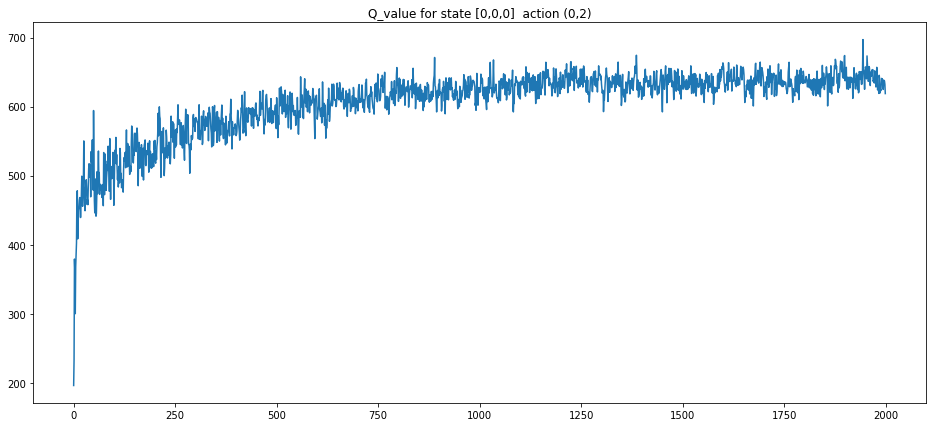

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent_arch2.states_tracked)))
plt.plot(xaxis,np.asarray(agent_arch2.states_tracked))
plt.show()

### Plotting rewards per episode

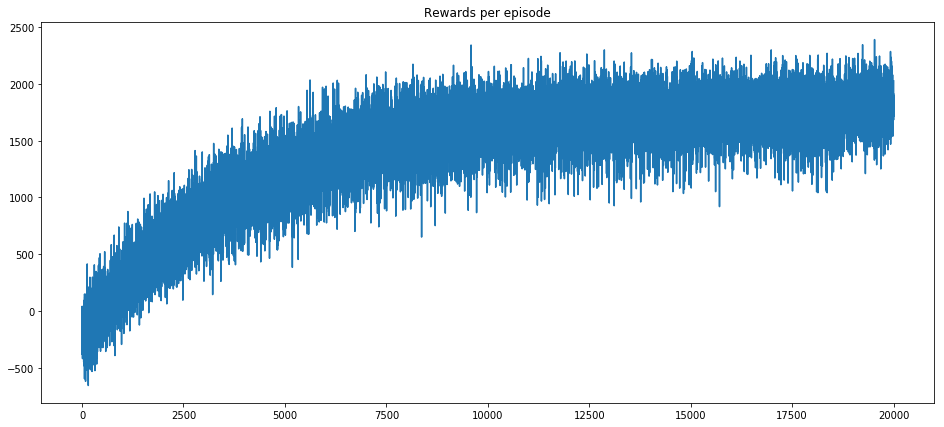

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_per_episode_arch2)))
plt.plot(xaxis,np.asarray(rewards_per_episode_arch2))
plt.show()

#### We do see some sort of stabilization of the rewards with increasing episodes, there are different actioons possible so there reward will differ individually but rewards per episode have moved on from nearly 0 to decent values 

### Epsilon-decay function used

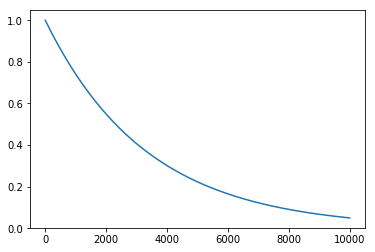

In [14]:
epsilon_max = 1
epsilon_min = 0.00001
epsilon_decay = 0.0003
time1 = [i for i in range(0,10000)]
epsilon = []
for episode in range(0,10000):
    #epsilon.append(0 + float(( 1 - .00001) * np.exp(-.0003*episode)))
    epsilon.append(float(epsilon_min + ( epsilon_max - epsilon_min) * np.exp(-epsilon_decay*episode)))
plt.plot(time1, epsilon)
plt.show()

##  <font color =green>Using the Saved model files to Load the final Saved model.</font>

In [15]:
from keras.models import model_from_json

In [16]:
# load json and create model
file = open("final_model_weights.json", 'r')
model_json = file.read()
file.close()

In [18]:
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("final_model_weights.h5")

In [19]:
loaded_model.predict(np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36))

array([[605.98193,   0.     , 618.78394, 641.3342 ,   0.     , 613.64514,
        635.8954 , 627.78735, 612.4153 ,   0.     , 646.5785 , 573.63184,
        579.4253 , 555.54175, 606.69635, 607.89996, 611.2475 , 596.9825 ,
        619.42236,   0.     , 633.6461 ]], dtype=float32)